In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import viz
from gluoncv.data import VOCDetection
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform, SSDDefaultValTransform

from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
from gluoncv.utils.metrics.coco_detection import COCODetectionMetric
from gluoncv.utils.metrics.accuracy import Accuracy

In [3]:
# define a class with VOC structure so roughy data plays nicely with Gluon
class VOCLike(VOCDetection):
    # these are the original classes that are not consistent across the deployments [ECO 112320]
    """
    CLASSES = ['orange_roughy_edge', 'orange_roughy', 'sea_anemone', 'sea_urchin', 'oreo',
               'whiptail', 'eel', 'shark', 'worm', 'misc_fish', 'mollusc', 'shrimp',
               'sea_star']
    """
    # these are the 11 final classes after the merge operation [ECO 112320]
    CLASSES = ['brittle_star', 'cnidaria', 'eel', 'misc_fish', 'mollusc', 'orange_roughy_edge', 
               'orange_roughy', 'sea_anemone', 'sea_feather', 'sea_star','sea_urchin']
    
    #CLASSES = ['person','dog']
    def __init__(self, root, splits, transform=None, index_map=None, preload_label=True):
        super(VOCLike, self).__init__(root, splits, transform, index_map, preload_label)

In [4]:
# define the data loader
def get_dataloader(net, train_dataset, val_dataset, data_shape, batch_size, num_workers, ctx):
    """Get dataloader."""
    width, height = data_shape, data_shape
    
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width), ctx))
    anchors = anchors.as_in_context(mx.cpu())
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    
    # the training data loader (with transforms)
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover',
        num_workers=num_workers)
    val_batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    
    # the validation loader 
    val_loader = gluon.data.DataLoader(
        val_dataset.transform(SSDDefaultValTransform(width, height)),
        batch_size, False, batchify_fn=val_batchify_fn, last_batch='keep',
        num_workers=num_workers)
    
    return train_loader, val_loader

In [6]:
roughy_train_dataset = VOCLike(root='VOCstarboardALL', splits=(('OP', 'OP12/train'),))
roughy_val_dataset = VOCLike(root='VOCstarboardALL', splits=(('OP', 'OP12/val'),))

print('Train:', len(roughy_train_dataset))
print('Val:', len(roughy_val_dataset))

Train: 100
Val: 26


label: [[7.420e+02 1.027e+03 1.017e+03 1.260e+03 8.000e+00 0.000e+00]
 [2.973e+03 1.701e+03 3.278e+03 2.040e+03 8.000e+00 0.000e+00]
 [1.104e+03 1.027e+03 1.419e+03 1.222e+03 1.000e+00 0.000e+00]
 [2.676e+03 1.778e+03 2.878e+03 1.932e+03 1.000e+00 0.000e+00]]


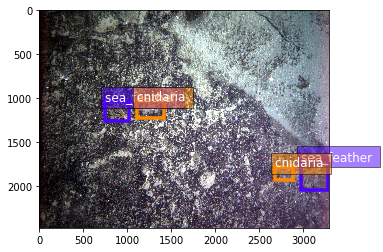

In [7]:
classes = ['brittle_star', 'cnidaria', 'eel', 'misc_fish', 'mollusc', 'orange_roughy_edge', 
               'orange_roughy', 'sea_anemone', 'sea_feather', 'sea_star','sea_urchin']

image, label = roughy_val_dataset[15]
print('label:', label)

# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

In [35]:
arough = []
#ptfs = glob.glob(os.path.join('/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCstarboardALL/OP/ImageSets/Main/','OP*/*.txt'))
ptfs = glob.glob(os.path.join('/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/OP/ImageSets/Main/','OP*/test.txt'))

In [24]:
import glob
import os

In [36]:
ptfs

['/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/OP/ImageSets/Main/OP19/test.txt',
 '/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/OP/ImageSets/Main/OP12/test.txt',
 '/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/OP/ImageSets/Main/OP16/test.txt']

In [37]:
for ptf in ptfs:
    with open(ptf, 'r') as ff:
        temp = list(ff)
        arough.extend(temp)

In [38]:
len(arough)

460

In [39]:
ind = int(np.floor(0.8*float(len(arough))))

In [40]:
ind

368

In [41]:
np.random.shuffle(arough)

In [42]:
with open('/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/OP/ImageSets/Main/OPall/train.txt','w') as ff:
    for line in arough[0:ind]:
        ff.write(line)

In [43]:
arough[0:10]

['20190715-014739-285\n',
 '20190713-041752-129\n',
 '20190715-015019-255\n',
 '20190715-015215-274\n',
 '20190715-014731-259\n',
 '20190715-014827-284\n',
 '20190715-015037-254\n',
 '20190714-065348-138\n',
 '20190714-065424-137\n',
 '20190713-041547-182\n']

In [44]:
with open('/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/OP/ImageSets/Main/OPall/val.txt','w') as ff:
    for line in arough[ind::]:
        ff.write(line)